In [ ]:
from SynTemp.SynUtils.utils import load_database, load_from_pickle
data = load_from_pickle('./Data/uspto/uspto_its_graph_rules_cluster.pkl.gz')

In [ ]:
from SynTemp.SynRule.rule_cluster import NaiveCluster
node_label_names = ["element", "charge"]
naive_cluster = NaiveCluster(node_label_names=node_label_names, node_label_default=["*", 0], edge_attribute="order")
its_graph_rules_cluster = naive_cluster.process_rules_clustering(data, rule_column='GraphRules')

In [ ]:
its_graph_rules_cluster[0]

In [ ]:
from SynTemp.SynUtils.utils import stratified_random_sample
import pandas as pd
sampled_data = stratified_random_sample(its_graph_rules_cluster, property_key='naive_cluster', samples_per_class=1, seed=23)
pd.DataFrame(sampled_data)['Reaction Type'].value_counts()

In [ ]:
single = [x['GraphRules'][2] for x in sampled_data if x['Reaction Type'] == 'Single Cyclic']
complex = [x['GraphRules'][2] for x in sampled_data if x['Reaction Type'] == 'Complex Cyclic']
neither = [x['GraphRules'][2] for x in sampled_data if x['Reaction Type'] == 'None']
acyclic = [x['GraphRules'][2] for x in sampled_data if x['Reaction Type'] == 'Acyclic']

In [ ]:
from SynTemp.SynVis.chemical_graph_vis import ChemicalGraphVisualizer
vis = ChemicalGraphVisualizer()
vis.graph_vis(complex[4], show_node_labels=True)

In [ ]:
from SynTemp.SynRule.rule_decompose import GraphRuleDecompose

In [ ]:
from copy import deepcopy
complex_graph = complex[11]
# Add nodes and edges to complex_graph with the required attributes

single_cyclic_graphs = deepcopy(single)
# Define your single cyclic graphs by adding nodes and edges with the required attributes

# Call the function
explained_graphs = GraphRuleDecompose.bfs_remove_isomorphic_subgraphs(complex_graph, single_cyclic_graphs)

if explained_graphs is not None:
    print("List of single cyclic graphs that explain the complex graph:", explained_graphs)
    GraphRuleDecompose.visualize_with_common_subgraphs(complex_graph, explained_graphs)
else:
    print("Some parts of the complex graph could not be explained by any of the single cyclic graphs.")

In [ ]:
import pandas as pd 

df = pd.read_csv('./Data/golden/golden_dataset.csv')
df.head(2)

from SynTemp.SynUtils.utils import load_database
data = load_database('./Data/golden/golden_aam_reactions.json.gz')
for key, value in enumerate(data):
    data[key]['ground_truth'] = df.iloc[key,0]

In [ ]:
from SynTemp.SynUtils.utils import load_database
data = load_database('./Data/golden/golden_aam_reactions.json.gz')
for key, value in enumerate(data):
    data[key]['ground_truth'] = df.iloc[key,0]

In [ ]:
pd.DataFrame(data).info()

In [ ]:
from SynTemp.SynAAM.aam_validator import AMMValidator 
for key, value in enumerate(data):
    try:
        AMMValidator.smiles_check(data[key]['ground_truth'], data[key]['rdt'])
    except:
        print(key)

In [ ]:
data[366]['rdt']

In [ ]:
from SynTemp.SynAAM.aam_validator import AMMValidator  
results = AMMValidator.validate_smiles(data=data, ground_truth_col='ground_truth', 
                                       mapped_cols=['rxn_mapper', 'graphormer', 'local_mapper', 'rdt'], 
                                       check_method='RC', 
                                       ignore_aromaticity=False, n_jobs=4, verbose=0)

In [ ]:
pd.DataFrame(results)[['mapper', 'accuracy']]

In [ ]:
from SynTemp.SynAAM.aam_validator import AMMValidator  
results = AMMValidator.validate_smiles(data=data, ground_truth_col='Ground turth', 
                                       mapped_cols=['RXNMapper', 'GraphMapper', 'LocalMapper'], 
                                       check_method='RC', 
                                       ignore_aromaticity=False, n_jobs=4, verbose=0)

In [ ]:
pd.DataFrame(results)[['mapper', 'accuracy']]

In [ ]:
pd.DataFrame(results)[['mapper', 'accuracy']]

In [ ]:
from SynTemp.SynUtils.utils import load_database
recon = load_database('./Data/Recon3D/Recon3D_aam_reactions.json.gz')

from SynTemp.SynAAM.aam_validator import AMMValidator  
results, _ = AMMValidator.validate_smiles(data=recon, ground_truth_col='ground_truth', 
                                       mapped_cols=['rxn_mapper', 'graphormer', 'local_mapper', 'rdt'], 
                                       check_method='RC', 
                                       ignore_aromaticity=False, n_jobs=4, verbose=0, ensemble=True)

In [ ]:
pd.DataFrame(recon).to_csv('./Data/Recon3D/Recon3D_aam_reactions.csv')

In [ ]:
import pandas as pd
pd.DataFrame(results)[['mapper', 'accuracy', 'success_rate']]

In [ ]:
import pandas as pd

In [ ]:
ecoli = pd.read_csv('./Data/ecoli/ecoli.smiles', header=None)
ecoli.rename({0:'ground_truth'}, axis=1, inplace=True)
ecoli['R-id'] = range(1, len(ecoli) + 1)

In [ ]:
from rdkit import Chem
from rdkit.Chem import rdChemReactions
ok = []
bug = []
for key, value in enumerate(ecoli['ground_truth']):
    try:
        rdChemReactions.ReactionFromSmarts(value)
        ok.append(key)
    except:
        bug.append(key)

In [ ]:
a,b,c =ecoli['ground_truth'][bug[0]].split('>>')

In [ ]:
from rdkit import Chem
Chem.MolFromSmiles(a)

In [ ]:
Chem.MolFromSmiles(b)

In [ ]:
Chem.MolFromSmiles(c)

In [ ]:
print(ecoli.iloc[bug,:]['ground_truth'])

In [ ]:
ecoli = ecoli.iloc[ok, :]
ecoli.reset_index(drop=True, inplace=True)
#ecoli = ecoli.to_dict('records')

In [ ]:
from rdkit import Chem
from typing import List, Optional
import re

def remove_atom_mapping(smiles: str) -> str:
    """
    Removes atom mapping numbers and simplifies atomic notation in a SMILES string.
    
    This function processes a SMILES string to:
    1. Remove any atom mapping numbers denoted by ':' followed by one or more digits.
    2. Simplify the atomic notation by removing square brackets around atoms that do not need them.
    
    Parameters:
    - smiles (str): The SMILES string to be processed.
    
    Returns:
    - str: The processed SMILES string with atom mappings removed and simplified atomic notations.
    """
    # Remove atom mapping numbers
    pattern = re.compile(r":\d+")
    smiles = pattern.sub("", smiles)
    # Simplify atomic notation by removing unnecessary square brackets
    pattern = re.compile(r"\[(?P<atom>(B|C|N|O|P|S|F|Cl|Br|I){1,2})(?:H\d?)?\]")
    smiles = pattern.sub(r"\g<atom>", smiles)
    return smiles

def mol_from_smiles(smiles: str) -> Optional[Chem.Mol]:
    """
    Converts a SMILES string to an RDKit Mol object, with error handling for invalid strings.
    
    Parameters:
    - smiles (str): The SMILES string to be converted.
    
    Returns:
    - Chem.Mol: An RDKit Mol object created from the given SMILES string. None if conversion fails.
    
    Raises:
    - ValueError: If the SMILES string is invalid and cannot be converted to a Mol object.
    """
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        raise ValueError(f"Invalid SMILES string: {smiles}")
    return mol

def filter_valid_molecules(smiles_list: List[str]) -> List[Chem.Mol]:
    """
    Filters a list of SMILES strings, converting them to RDKit Mol objects, while ignoring invalid or empty molecules.
    
    Parameters:
    - smiles_list (List[str]): A list of SMILES strings to be processed.
    
    Returns:
    - List[Chem.Mol]: A list of RDKit Mol objects derived from valid, non-empty SMILES strings in the input list.
    """
    valid_molecules = []
    for smiles in smiles_list:
        try:
            mol = mol_from_smiles(smiles)
            if mol.GetNumAtoms() > 0:
                valid_molecules.append(mol)
        except ValueError:
            continue
    return valid_molecules

def standardize_rsmi(rsmi: str) -> str:
    """
    Standardizes a reaction SMILES (rSMI) by ensuring that all reactants and products are valid molecules with atoms.
    
    The function splits the reaction into reactants and products, filters and validates them, and then
    assembles them back into a standardized reaction SMILES string.
    
    Parameters:
    - rsmi (str): The reaction SMILES string to be standardized.
    
    Returns:
    - str: The standardized reaction SMILES string with valid and non-empty reactants and products.
    """
    reactants, products = rsmi.split('>>')
    reactant_molecules = filter_valid_molecules(reactants.split('.'))
    product_molecules = filter_valid_molecules(products.split('.'))

    # Convert molecules back to SMILES and assemble the standardized reaction SMILES string
    standardized_reactants = '.'.join(Chem.MolToSmiles(mol) for mol in reactant_molecules)
    standardized_products = '.'.join(Chem.MolToSmiles(mol) for mol in product_molecules)

    return f"{standardized_reactants}>>{standardized_products}"


ecoli['ground_truth'] = ecoli['ground_truth'].apply(standardize_rsmi)


In [ ]:
import re
def remove_atom_mapping(smiles: str) -> str:
    pattern = re.compile(r":\d+")
    smiles = pattern.sub("", smiles)
    pattern = re.compile(r"\[(?P<atom>(B|C|N|O|P|S|F|Cl|Br|I){1,2})(?:H\d?)?\]")
    smiles = pattern.sub(r"\g<atom>", smiles)
    return smiles
ecoli['reactions'] = ecoli['ground_truth'].apply(remove_atom_mapping)
ecoli = ecoli.to_dict('records')

In [ ]:
from SynTemp.SynUtils.utils import save_database
save_database(ecoli, './Data/ecoli/ecoli_reactions.json.gz')

In [ ]:
Chem.MolFromSmiles(ecoli.loc[189, 'reactions'])

In [ ]:
bug

In [ ]:

rxn = rdChemReactions.ReactionFromSmarts('[C:1](=[O:2])O.[N:3]>>[C:1](=[O:2])[N:3]')
reacts = (Chem.MolFromSmiles('C(=O)O'),Chem.MolFromSmiles('CNC'))
products = rxn.RunReactants(reacts)

In [ ]:
from SynTemp.SynUtils.utils import load_database
recon = load_database('./Data/Recon3D/Recon3D_aam_reactions.json.gz')

from SynTemp.SynAAM.aam_validator import AMMValidator  
results, _ = AMMValidator.validate_smiles(data=recon, ground_truth_col='ground_truth', 
                                       mapped_cols=['rxn_mapper', 'graphormer', 'local_mapper'], 
                                       check_method='RC', 
                                       ignore_aromaticity=False, n_jobs=4, verbose=0, ensemble=True)

import pandas as pd
pd.DataFrame(results)[['mapper', 'accuracy', 'success_rate']]

In [ ]:
recon[0]

In [ ]:
from SynTemp.SynUtils.utils import load_database
recon = load_database('./Data/ecoli/ecoli_aam_reactions.json.gz')

from SynTemp.SynAAM.aam_validator import AMMValidator  
results, _ = AMMValidator.validate_smiles(data=recon, ground_truth_col='ground_truth', 
                                       mapped_cols=['rxn_mapper', 'graphormer', 'local_mapper', 'rdt', 'ground_truth'], 
                                       check_method='RC', 
                                       ignore_aromaticity=False, n_jobs=4, verbose=0, ensemble=False)

import pandas as pd
pd.DataFrame(results)[['mapper', 'accuracy', 'success_rate']]

In [ ]:
test = pd.DataFrame(recon).drop(['reactions'], axis =1)
test['local_mapper_result'] = pd.DataFrame(results).loc[2, 'results']
test['rxn_mapper_result'] = pd.DataFrame(results).loc[0, 'results']
test['graphormer_result'] = pd.DataFrame(results).loc[1, 'results']
test['rdt_result'] = pd.DataFrame(results).loc[3, 'results']

In [ ]:
test.to_csv('./Data/ecoli/ecoli_aam_reactions.csv')

In [ ]:
pd.DataFrame(results)

In [ ]:
pd.DataFrame(results).loc[2, 'results']

In [ ]:
test_2 = test[['local_mapper_result', 'rxn_mapper_result', 'graphormer_result', 'rdt_result']]

In [ ]:
def ensemble_results(df, threshold):
    # Calculate the sum of True values in each row
    true_counts = df.sum(axis=1)
    # Apply the threshold to determine the final result
    final_results = true_counts >= threshold
    return final_results

test_3 = ensemble_results(test_2, 2)

In [ ]:
test_3.sum()/273

In [ ]:
uspto_sample = pd.read_csv('./Data/aam_benchmark/USPTO_sampled.csv')

In [ ]:
uspto_sample['LocalMapper_correct'].sum()

In [ ]:
uspto_sample

# Bug

In [ ]:
import pandas as pd 

df = pd.read_csv('./Data/aam_benchmark/Golden_mappings.csv')
df = pd.read_csv('./Data/aam_benchmark/benchmark.csv')
df = pd.read_csv('./Data/aam_benchmark/NatComm_mappings.csv')
df = pd.read_csv('./Data/aam_benchmark/USPTO_sampled.csv')
df = pd.read_csv('./Data/ecoli/ecoli_aam_reactions.csv')
#df = pd.read_csv('./Data/Recon3D/Recon3D_aam_reactions.csv')
df.head(1)

In [ ]:
from SynTemp.SynAAM.aam_validator import AMMValidator  
results, _ = AMMValidator.validate_smiles(data=df, ground_truth_col='ground_truth', 
                                       mapped_cols=['ground_truth'], 
                                       check_method='RC', 
                                       ignore_aromaticity=False, n_jobs=4, verbose=0, ensemble=False)

import pandas as pd
pd.DataFrame(results)[['mapper', 'accuracy', 'success_rate']]

In [ ]:
test_0 = df[['ground_truth', 'R-id']]
test_0['results'] = results[0]['results']

In [ ]:
test_0_bug = test_0.loc[test_0['results']==False, :]

In [ ]:
rsmi = test_0_bug['ground_truth'][74]

In [ ]:
from SynTemp.SynITS.its_construction import ITSConstruction
from SynTemp.SynITS.its_extraction import ITSExtraction
reactants, products = rsmi.split('>>')
G, H = ITSExtraction.graph_from_smiles(reactants), ITSExtraction.graph_from_smiles(products)

In [ ]:
rsmi

In [ ]:
reactants

In [ ]:
from rdkit import Chem
Chem.MolFromSmiles(reactants)

In [ ]:
from SynTemp.SynVis.reaction_visualizer import ReactionVisualizer
vis = ReactionVisualizer()

In [ ]:
vis.visualize_reaction(test_0_bug.iloc[0]['ground_truth'])

In [ ]:
test_0_bug.iloc[0]['ground_truth']

In [ ]:
import pandas as pd


df = pd.read_csv('./Data/USPTO_50K/USPTO_50K.csv')
df.drop_duplicates(subset=['reactions'], inplace=True)
df['R-id'] = ['USPTO-' + str(i) for i in range(len(df))]
df.head(2)

# MOD

In [ ]:
from SynTemp.SynRule.rule_executor import RuleExecutor
test = RuleExecutor.reaction_prediction(input_smiles=['C=C1C(=C)C2OC1C1=C2CC(C(C)=O)CC1'],
                                        rule_file_path='./Data/uspto/Rule/USPTO_50K_31.gml',
                                        prediction_type='backward', repeat_times=1, print_results=False)

test

In [ ]:
from SynTemp.SynRule.rule_executor import RuleExecutor
from SynTemp.SynUtils.utils import load_database
database = load_database('./test_database.json.gz')
test = RuleExecutor.reaction_database_prediction(database=database[:],  rule_file_path='./Data/uspto/Rule/',
                                         original_rsmi_col='reactions', prediction_type = 'backward', repeat_times=1)


In [ ]:
from SynTemp.SynRule.rule_benchmark import RuleBenchmark
from SynTemp.SynUtils.utils import load_database
database = load_database('./test_database.json.gz')
fw, bw = RuleBenchmark.reproduce_reactions(database=database[:],  id_col='R-id', rule_file_path='./Data/uspto/Rule',
                                         original_rsmi_col='reactions', repeat_times=1)

In [ ]:
import pandas as pd
pd.DataFrame(bw).info()

# Ranking

In [ ]:
from SynTemp.SynUtils.utils import load_database
from SynTemp.SynRule.rule_benchmark import RuleBenchmark
database = load_database('./test_database.json.gz')
fw, bw = RuleBenchmark.reproduce_reactions(database=database[:],  id_col='R-id', rule_file_path='./Data/uspto/Rule',
                                         original_rsmi_col='reactions', repeat_times=1, prior=True)

In [ ]:
import pandas as pd
pd.DataFrame(bw).info()

In [ ]:
from SynTemp.SynRule.similarity_ranking import SimilarityRanking


processed_dicts = SimilarityRanking.process_list_of_dicts(fw, 'unrank', ['FCFP6'])
print("Top 5 accuracy:", RuleBenchmark.TopKAccuracy(processed_dicts, 'reactions','rank', 2, ignore_stero=True))

In [ ]:
processed_dicts = SimilarityRanking.process_list_of_dicts(fw, 'unrank', ['RDK7'])
print("Top 5 accuracy:", RuleBenchmark.TopKAccuracy(processed_dicts, 'reactions','rank', 5, ignore_stero=True))

## Visualize

In [1]:
from SynTemp.SynUtils.utils import load_database
data = load_database('./Data/uspto_sample/uspto_sample_aam_reactions.json.gz')

In [2]:
from SynTemp.SynVis.chemical_reaction_visualizer import ChemicalReactionVisualizer
vis = ChemicalReactionVisualizer()
vis.visualize_and_compare_reactions(data[0], num_cols=3)

[22:10:46] reactant 0 has no mapped atoms.
[22:10:46] reactant 1 has no mapped atoms.
[22:10:46] reactant 2 has no mapped atoms.
[22:10:46] reactant 3 has no mapped atoms.
[22:10:46] reactant 4 has no mapped atoms.
[22:10:46] reactant 6 has no mapped atoms.
[22:10:46] reactant 0 has no mapped atoms.
[22:10:46] reactant 1 has no mapped atoms.
[22:10:46] reactant 2 has no mapped atoms.
[22:10:46] reactant 3 has no mapped atoms.
[22:10:46] reactant 4 has no mapped atoms.
[22:10:46] reactant 6 has no mapped atoms.
[22:10:46] reactant 0 has no mapped atoms.
[22:10:46] reactant 1 has no mapped atoms.
[22:10:46] reactant 2 has no mapped atoms.
[22:10:46] reactant 3 has no mapped atoms.
[22:10:46] reactant 4 has no mapped atoms.
[22:10:46] reactant 6 has no mapped atoms.
[22:10:46] mapped atoms in the reactants were not mapped in the products.
  unmapped numbers are: 2 1 3 4 5 6 7 13 14 15 16 8 9 10 11 12 17 18 19 20 21 22 23 38 37 36 41 40 39 
[22:10:46] mapped atoms in the reactants were not

[22:12:21] reactant 0 has no mapped atoms.
[22:12:21] reactant 1 has no mapped atoms.
[22:12:21] reactant 2 has no mapped atoms.
[22:12:21] reactant 3 has no mapped atoms.
[22:12:21] reactant 4 has no mapped atoms.
[22:12:21] reactant 6 has no mapped atoms.


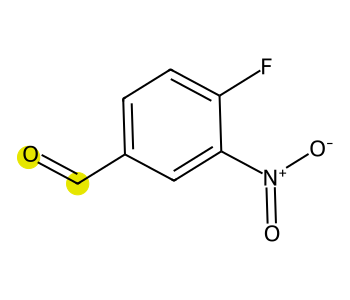

In [5]:
from SynTemp.SynVis.its_visualizer import ITSVisualizer
from IPython.display import Image
its_vis = ITSVisualizer(data[0]['rxn_mapper'])
display(Image(its_vis.draw_product_with_modified_bonds()))